In [4]:
# Recurrent Neural Networks - LSTM
%matplotlib inline

from __future__ import print_function

import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"


import numpy as np
import matplotlib.pyplot as plt
import pandas
import math


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

plt.style.use('ggplot')


In [5]:
# fix random seed for reproducibility
np.random.seed(10)

In [ ]:
#Use the flood_data.csv dataset
dataframe = pandas.read_csv('dataset/flood_train.csv', usecols=[1], engine='python', skipfooter=3)
dataset   = dataframe.values
dataset   = dataset.astype('float32')
dataframe.head()

,waterlevel
0,0.27
1,0.26
2,0.27
3,0.28
4,0.28


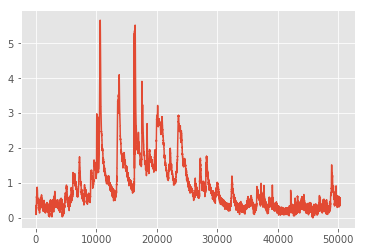

In [7]:
plt.plot(dataset)

In [8]:
# normalize the dataset
scaler  = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [9]:
# split into train and test sets
percentage_test = 0.80
train_size  = int(len(dataset) * percentage_test)
test_size   = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

40251 10063


--- Training Data --- 80.0 % ---


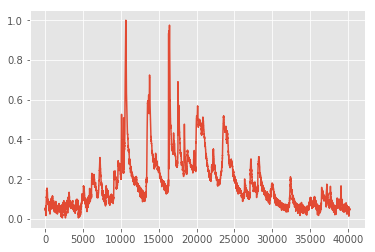

--- Test Data --- 20.0 % ---


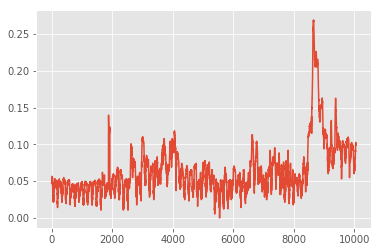

In [10]:
print('--- Training Data ---', percentage_test * 100, '% ---')
plt.plot(train)
plt.show()
print('--- Test Data ---', 100-(percentage_test * 100), '% ---')
plt.plot(test)
plt.show()

In [11]:
# This function creates a sliding window of the dataset.
def create_dataset(dataset, sliding_window=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-sliding_window-1):
        a = dataset[i:(i+sliding_window), 0]
        dataX.append(a)
        dataY.append(dataset[i + sliding_window, 0])
    return np.array(dataX), np.array(dataY)

In [12]:
# use a n-10 sliding window equivalent to 2.5 hours of historical data
slide_window   = 10
trainX, trainY = create_dataset(train, slide_window)
testX, testY   = create_dataset(test, slide_window)

In [13]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX  = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
#Setup the LSTM

model = Sequential()
model.add(LSTM(4, input_dim=slide_window))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=50, batch_size=1, verbose=2)

In [ ]:
# Print out the evaluation for both the
trainScore = model.evaluate(trainX, trainY, verbose=0)
trainScore = math.sqrt(trainScore)
trainScore = scaler.inverse_transform(np.array([[trainScore]]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = model.evaluate(testX, testY, verbose=0)
testScore = math.sqrt(testScore)
testScore = scaler.inverse_transform(np.array([[testScore]]))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
 
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[slide_window:len(trainPredict)+slide_window, :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(slide_window*2)+1:len(dataset)-1, :] = testPredict
 
# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
plt.plot(testPredict)
plt.plot(testY)

In [ ]:
# Test the network on an unseen data
unseen = pandas.read_csv('dataset/flood_test.csv',sep=',')

In [ ]:
unseen.head()

In [ ]:
unseen_test = unseen['waterlevel'].values

In [ ]:
plt.plot(unseen_test[0:20000])

In [ ]:
unseen_clean = []
for i in unseen_test:
    unseen_clean.append([i])
unseen_clean = np.asarray(unseen_clean).astype('float32')
unseen_clean = scaler.fit_transform(unseen_clean)

In [ ]:
features,labels = create_dataset(unseen_clean, slide_window)
features        = np.reshape(features, (109186,1, 10)) 

In [ ]:
unseen_results = model.predict(features)

In [ ]:
plt.gca().set_ylim(bottom=0)
plt.gca().set_ylim(top=1)

print('-------------------- Predicted --------------------')
plt.plot(unseen_results)
plt.show()


print('-------------------- Ground Truth --------------------')
plt.plot(labels)
plt.show()

In [ ]:
# Check the root mean squared error for the new test set

testScore = model.evaluate(features, labels, verbose=0)
testScore = math.sqrt(testScore)
testScore = scaler.inverse_transform(np.array([[testScore]]))
print('Test Score: %.2f RMSE' % (testScore))


#### Checking the first 20000 data shows that the network is relatively comfortable on predicting ahead of time flood level values when the flood level  aren't extreme

In [ ]:
plt.gca().set_ylim(bottom=0)
plt.gca().set_ylim(top=1)

print('----------------- Predicted ---------------')
plt.plot(unseen_results[0:20000])
plt.show()

print('----------------- Ground Truth ---------------')
plt.plot(labels[0:20000])
plt.show()